In [92]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from node2vec import Node2Vec
from collections import Counter
from tqdm import tqdm
from gensim.models import Word2Vec
import seaborn as sns

## EDA

In [ ]:
# Finding all possible answers in a column to capture if there are any weird answers

print(df['event_name'].value_counts())
print("")
print(df['item_id'].value_counts()) # I can see with this what most popular products are. Some id's are shorter in length because excel doesn't capture a 0 at the beginning of a number.
print("")
print(df['item_brand'].value_counts()) # See what the most popular brand is
print("")
print(df['item_category'].value_counts()) # only contains (not_set)
print("")
print(df['item_category2'].value_counts()) # Contains a lot of (not_set)
print("")
print(df['item_category3'].value_counts()) # Contains a lot of (not_set)
print("")
print(df['item_category4'].value_counts()) # Contains a lot of (not_set)
print("")
print(df['item_category5'].value_counts()) # Contains a lot of (not_set)
print("")
print(df['item_variant'].value_counts()) # does not contain any data.
print("")
print(df['quantity'].value_counts()) # Shows what kind of quantity's there are
print("")
print(df['item_revenue'].value_counts()) # Shows what kind of revenue's  there are.

In [ ]:
# Finding all the unique values in the event_name, item_category, and item_variant columns

print('Unique values event_name:')
print(df['event_name'].unique())
print("")
print('Unique values item_category:')
print(df['item_category'].unique()) # only has not set and nan values
print("")
print('Unique values item_variant:')
print(df['item_variant'].unique()) # only has nan values
print("")

In [ ]:
# finding the number of unique items
print(df['item_id'].nunique()) 

In [100]:
# creating a list of all items in dataset for later purpose
all_item_ids = df.item_id.values.tolist()

In [ ]:
# Checking the data types of the features

df.dtypes 

In [ ]:
# Checking missing data

df.isnull().sum()

# Price contains missing data
# Item_brand contains missing data
# All the item_category's contain missing data but is not fully captured by this code. See previous cells.
# Item_variant does not contain any data
# Quantity and revenue are containing a lot of missing data because they are only relevant when a product is purchased.

In [103]:
# Chose to drop item_variant, and category columns because they contain a lot of missing data. 

df.drop(columns='item_variant', inplace=True)
df.drop(columns='item_category', inplace=True)
df.drop(columns='item_category2', inplace=True)
df.drop(columns='item_category3', inplace=True)
df.drop(columns='item_category4', inplace=True)
df.drop(columns='item_category5', inplace=True)

In [ ]:
# viewing event distribution

df['event_name'].value_counts().plot(kind='bar')

In [ ]:
# checking amount of sessions in whole dataset
ses_am = df.groupby('session_id')['event_name', 'item_id', 'price', 'item_brand', 'quantity', 'item_revenue', 'page'].agg(list).reset_index()
ses_am

In [106]:
# selecting the sessions that do not contain a purchase.

# Grouping the data by session_id and apply a lambda function to each group
filtered_df = df.groupby('session_id').apply(lambda x: x[x['event_name'] != 'purchase'])

# Resetting the index of the resulting DataFrame
filtered_df = filtered_df.reset_index(drop=True)

In [ ]:
# finding the most interacted products in non_purchase dataset
top_5_interact = filtered_df['item_id'].value_counts().head(5)
top_5_interact

In [ ]:
top_5_interact.plot(kind='bar', color='#003060')
plt.title('Top 5 Most Interacted Products in non-purchase sessions')
plt.xlabel('Product')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45, color='#986B23')
plt.ylim(0, 35000)
plt.show()

In [ ]:
# finding the most interacted brands in non_purchase dataset
top_5_interact_brands = filtered_df['item_brand'].value_counts().head(5)
top_5_interact_brands

In [ ]:
top_5_interact_brands.plot(kind='bar', color='#003060')
plt.suptitle('Top 5 Most Interacted Brands in non-purchase sessions', y=1.0)
plt.xlabel('Brands')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45, color='#986B23')
plt.show()

In [ ]:
# Grouping the non_purchase data by session to compute the average session length
filtered_df = filtered_df.groupby('session_id')['event_name', 'item_id', 'price', 'item_brand', 'quantity', 'item_revenue', 'page'].agg(list).reset_index()

In [ ]:
# adding a length column for later purpose
filtered_df['length'] = filtered_df['event_name'].apply(lambda x: len(x))
filtered_df

In [ ]:
#calculating average length per session in non_purchase sessions: amount of sessions is 108.453 in dataset

print(filtered_df['length'].sum())
average_non_purchase = 6712665/108453
print('average session length of non_purchase sessions in dataset =', average_non_purchase)

In [ ]:
# Creating dataframe of sessions that contain at least one purchase and grouping them to get a session_id per row

purchase_session_ids = df[df['event_name'].apply(lambda x: 'purchase' in x)]['session_id'].unique().tolist()
purchase_data = df[df['session_id'].isin(purchase_session_ids)]
purchase_data = purchase_data.groupby('session_id')['event_name', 'item_id', 'price', 'item_brand', 'quantity', 'item_revenue', 'page'].agg(list).reset_index()

In [ ]:
# checking if i get the right result
purchase_data

In [116]:
# computing the length column again to compute the length per session which contain at least one purchase

purchase_data['length'] = purchase_data['event_name'].apply(lambda x: len(x))

In [ ]:
#calculating average length per session in sessions that contain at least one purchase: amount of sessions is 4383 in dataset

print(purchase_data['length'].sum()) # total length is 1967567
average_purchase = 1967567/4383
print('average session length of non_purchase sessions in dataset =', average_purchase)

In [ ]:
# Creating a plot to show the difference in average length across purchase and
# non-purchase sessions


bars = plt.bar([1, 2], [average_purchase, average_non_purchase])


for bar in bars:
    if bar.get_height() > 70:
        bar.set_color('#003060')
    else:
        bar.set_color('#986B23')


plt.ylabel("Average Length (events)")
plt.xlabel("Session Type")
plt.xticks([1, 2], ["At least one purchase", "Non-Purchase"], color='#986B23')
plt.title("Average Length of Purchase and Non-Purchase Sessions")
plt.ylim(0, 500)


plt.show()

In [119]:
# doing some EDA on sessions that contain a purchase

purchases = df[df['event_name'] == 'purchase']

In [ ]:
# finding the most sold product in dataset
top_5_products = purchases['item_id'].value_counts().head(5)
top_5_products

In [ ]:
# finding the most sold product in dataset

top_5_products.plot(kind='bar', color='#003060')
plt.title('Top 5 Most Sold Products')
plt.xlabel('Product')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45, color='#986B23')
plt.ylim(0, 250)
plt.show()


In [ ]:
top_5_brands = purchases['item_brand'].value_counts().head(5)

top_5_brands

In [ ]:
# finding the most sold brand in dataset

top_5_brands.plot(kind='bar', color='#003060')
plt.title('Top 5 Most Sold Brands')
plt.xlabel('Brand')
plt.ylabel('Number of Sales')
plt.xticks(rotation=45, color='#986B23')
plt.ylim(0, 20000)
plt.show()

# Preprocessing

In [ ]:
df = df.groupby('session_id')['event_name', 'item_id', 'event_timestamp'].agg(list).reset_index()

In [ ]:
# computing the length function to keep sessions that are between length 5 and 500
df['length'] = df['event_name'].apply(lambda x: len(x))
df

In [ ]:
# Droping rows where length is smaller than 5 or bigger than 10
df = df.drop(df[(df['length'] < 5) | (df['length'] > 500)].index)

# Checking the df
df

In [ ]:
# checking max and min length

print(df['length'].max())
print(df['length'].min())

In [129]:
# dont need it anymore for now
df.drop(columns='length', inplace=True)

In [130]:
# creating a dataframe that contains items that occur before a purchase which will be serving 
# as x values and purchase in a session will be serving as a y value.

output = []
non_purchase_events = []
non_purchase_item_ids = []
prev_session_id = df.iloc[0]['session_id']
for _, row in df.iterrows():
    session_id = row['session_id']
    if session_id != prev_session_id:
        non_purchase_events = []
        non_purchase_item_ids = []
    for event, item_id in zip(row['event_name'], row['item_id']):
        if event == 'purchase':
            output.append({'session_id': session_id, 
                           'purchase_event': event, 
                           'purchase_item_id': item_id,
                           'non_purchase_events_before_purchase': non_purchase_events,
                           'non_purchase_item_ids_before_purchase': non_purchase_item_ids})
        else:
            non_purchase_events.append(event)
            non_purchase_item_ids.append(item_id)
    prev_session_id = session_id

result = pd.DataFrame(output)

#reordering the columns
result = result[['session_id', 'non_purchase_events_before_purchase', 
                 'non_purchase_item_ids_before_purchase', 'purchase_event', 'purchase_item_id']]

In [ ]:
# checking result
result

In [132]:
# adding length column for checking the lengths of sessions again 
result['length'] = result['non_purchase_events_before_purchase'].apply(lambda x: len(x))

In [ ]:
# finding the max and min length
print(result['length'].max())
print(result['length'].min())

In [ ]:
# dropping sessions that only contain a purchase without any events before
result = result.drop(result.loc[result['length'] == 0].index)

# checking if the right result is generated
print(result['length'].min())

I created a dataset which contains sessions that contain at least 1 purchase. For training purposes I created non purchase events that occur before a purchase which are the x values, and the purchase is now the y value. 

In [ ]:
# find biggest session
print(result['length'].max())

In [ ]:
# checking how many different sessions there are
result['session_id'].nunique()


In [ ]:
#calculating average length per session: amount of sessions is 3312 in dataset

print(result['length'].sum()) # total length is 4024207
average = 4024207/3312
print('average length per session in dataset =', average)

In [ ]:
# Checking the definitive dataset that is used as input for models
result.to_csv('result.csv')
result

## Baseline method

In [142]:
# creating train test split
train_data, test_data = train_test_split(result, test_size=0.20)

In [143]:
# getting items per row
train_data = train_data.explode('non_purchase_item_ids_before_purchase')

In [144]:
# getting items per row
test_data = test_data.explode('non_purchase_item_ids_before_purchase')

In [145]:
# computing the popularity of items in the training set by counting the number of interactions for each item and storing the results in a dictionary.
item_popularity = train_data.groupby('non_purchase_item_ids_before_purchase')['session_id'].count()

In [146]:
# Sorting the items by popularity, in descending order.
item_popularity_sorted = item_popularity.sort_values(ascending=False)

In [ ]:
# Recommend the top N items to the user by selecting the first N items from the sorted list of item popularity.
top_n_item = item_popularity_sorted.head(1)
top_n_item

In [148]:
top_n_item = '0941443'

In [149]:
# adding a column to test set which respresent the item that is recommended
test_data['recommendations'] = test_data.apply(lambda x: top_n_item, axis=1)

In [ ]:
test_data

In [151]:
# creating the y_test and y_preds variables
y_test = test_data['purchase_item_id']
y_preds = test_data['recommendations']

In [152]:
# defining a function to find the succesful recommendations

def find_successes(y_pred, y_true):
  successes = []
  for pred in y_pred:
    if pred in y_true:
      successes.append(pred)
      
  return successes

# finding succesful recommendations

successes = find_successes(y_preds, y_test)

In [153]:
# defining the function for hit rate

def hit_ratio(recommendations, successes):
  n_recommendations = len(recommendations)
  n_successes = len(successes)
  hit_ratio = n_successes / n_recommendations
  
  return hit_ratio

hit_ratio_base = hit_ratio(y_preds, successes)

print(hit_ratio_base)

In [ ]:
# creating bar plot to visualize the hit ratio


plt.figure(figsize=(3, 3))
plt.bar([''], [hit_ratio_base], color='#003060')
plt.xlabel('Hits across true labels', color='#986B23')
plt.ylabel('Hit Ratio')
plt.ylim(0, 1)

plt.show()

In [156]:
# defining x_test to find top 50 most popular items which predictions are going to be compared to

x_test = test_data['non_purchase_item_ids_before_purchase']

In [ ]:
# finding the popular items in test set so i can assess how model is performing across popular items and if popular items will likely result in purchase

counter = Counter(x_test)

most_common = counter.most_common(50)

most_common_items = [x[0] for x in most_common]

print(most_common_items)

In [ ]:
# finding successes across popular products and computing the hit ratio
successes = find_successes(y_preds, most_common_items)
hit_ratio_pop_base = hit_ratio(y_preds, successes)

In [ ]:
print(hit_ratio_pop_base)

In [ ]:
# creating bar plot to visualize the hit ratio across top 50 popular products in test set

plt.figure(figsize=(3, 3))
plt.bar([''], [hit_ratio_pop_base], color='#003060')

plt.xlabel('Hits across top 50 populair products', color='#986B23')
plt.ylabel('Hit Ratio')
plt.ylim(0, 1)

plt.show()

In [ ]:
# Converting y_test into binary values to generate confusion matrix
y_test_binary = [0] * len(all_item_ids)
for item_id in y_test:
    y_test_binary[all_item_ids.index(item_id)] = 1

# Converting y_preds into binary values to generate confusion matrix
y_preds_binary = [0] * len(all_item_ids)
for item_id in y_preds:
    y_preds_binary[all_item_ids.index(item_id)] = 1

confusion_mat_perc = confusion_matrix(y_test_binary, y_preds_binary, normalize='true')

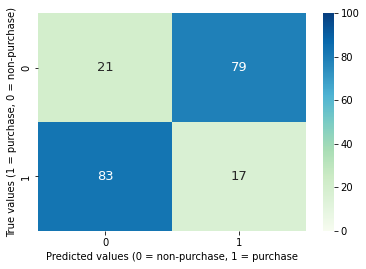

In [180]:
sns.heatmap(confusion_mat_perc, cmap='GnBu', annot=True, annot_kws={"size": 13}, vmin=0, vmax=100)
plt.xlabel('Predicted values (0 = non-purchase, 1 = purchase')
plt.ylabel('True values (1 = purchase, 0 = non-purchase)')
plt.show()

# Creating the knowledge graph

In [165]:
# getting the items per column to be compatible as input for knowledge graph. 
result = result.explode('non_purchase_item_ids_before_purchase')

In [167]:
# creating train test split. Training data will be used as input for the knowledge graph. The models will learn from this knowledge graph.
# the predictions will be done based on the non_purchase_item_ids_before_purchase in x_test. The models will be evaluated by comparing y_pred with y_test.

train_df, test_df = train_test_split(result, test_size=0.20)
 

In [168]:
# only need to create x_test and y_test for evaluation purpose later on. x_train and y_train is not necessary because knowledge graph takes dataset as
# first input and then you can define the columns of this dataset as source (which serves as x) and target (which serves as y).
x_test = test_df.non_purchase_item_ids_before_purchase.values.tolist()
y_test = test_df.purchase_item_id.values.tolist()

In [ ]:
# knowledge graph is created from training data
graph = nx.from_pandas_edgelist(train_df,source='non_purchase_item_ids_before_purchase',target='purchase_item_id'
,edge_attr='session_id',create_using=nx.DiGraph())
print(nx.info(graph))

In [170]:
selected_rows = result[result['length'] == 10]

In [ ]:
# generating an example of knowledge graph with 3 sessions
G = nx.DiGraph()


G.add_edge(1150013, 7501994)
G.add_edge(8212712, 7501994) 
G.add_edge(7505042, 7501994)
G.add_edge(7501994,7501994)
G.add_edge(8402000,8402000)
G.add_edge(8405310,8402000)
G.add_edge(7501811,8402000)
G.add_edge(468037,8402000)
G.add_edge(8402000,8405310)
G.add_edge(7467280,1530216)
G.add_edge(7467408,1530216)

edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw(G, with_labels=True)
nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=edge_labels)
plt.show()

## Applying Node2Vec

In [ ]:
# computing the n2v model
g_emb = Node2Vec(graph)


WINDOW = 1 
MIN_COUNT = 5 
BATCH_WORDS = 4 

mdl = g_emb.fit(
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

# Getting the node embeddings
embeddings = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in graph.nodes()],
        index = graph.nodes
    )
)



In [ ]:
# finding the most popular item that is purchased to replace an item if the knowledge graph was not able to capture an item id

counter = Counter(y_test)

most_common = counter.most_common(1)

print(most_common)

In [ ]:
# Get the predictions for each input

inputs = x_test
y_preds = []
replacement_item = '0700090'

for i in inputs:
    try:
        prediction = [item[0] for item in mdl.wv.most_similar(i, topn=1)]
        y_preds.append(prediction)
    except KeyError:
        print(f"{i} not in vocabulary, using {replacement_item} instead")
        prediction = [item[0] for item in mdl.wv.most_similar(replacement_item, topn=1)]
        y_preds.append(prediction)



In [1]:
def find_successes(y_pred, y_true):
  
  successes = []
  for pred in y_pred:
    if pred in y_true:
      successes.append(pred)
      
  return successes

successes = find_successes(y_preds, y_test)

In [2]:
# computing hit ratio
hit_ratio = hit_ratio(y_preds, successes)

In [ ]:
print(hit_ratio)

In [ ]:
# creating a plot
plt.figure(figsize=(3, 3))
plt.bar([''], [hit_ratio], color='#003060' )

plt.xlabel('Hits across true labels', color='#986B23')
plt.ylabel('Hit Ratio')
plt.ylim(0, 1)

plt.show()

In [ ]:
# finding the popular items in test set so i can assess how model is performing across popular items and if popular items will likely result in purchase

# create a counter object
counter = Counter(x_test)

# get the most common item
most_common = counter.most_common(50)

# Only get the elements
most_common_items = [x[0] for x in most_common]

print(most_common_items)

In [112]:
# finding succesful recommendations across top 50 popular products in test set
successes = find_successes(y_preds, most_common_items)

In [ ]:
# computing the hit ratio
hit_ratio_pop = hit_ratio(y_preds, successes)

In [ ]:
print(hit_ratio_pop)

In [ ]:
# creating a plot
plt.figure(figsize=(3, 3))
plt.bar([''], [hit_ratio_pop], color='#003060')

plt.xlabel('Hit ratio across popular products', color='#986B23')
plt.ylabel('Hit ratio')
plt.ylim(0, 1)

plt.show()

In [139]:
# Converting y_test into binary values
y_test_binary = [0] * len(all_item_ids)
for item_id in y_test:
    y_test_binary[all_item_ids.index(item_id)] = 1

# Converting y_preds into binary values
y_preds_binary = [0] * len(all_item_ids)
for item_id in y_preds:
    y_preds_binary[all_item_ids.index(item_id)] = 1

confusion_mat_perc = confusion_matrix(y_test_binary, y_preds_binary, normalize='true')

In [ ]:
sns.heatmap(confusion_mat_perc, cmap='GnBu', annot=True, annot_kws={"size": 13}, vmin=0, vmax=100)
plt.xlabel('Predicted values (1 = purchase, 0 = non-purchase')
plt.ylabel('True values (1 = purchase, 0 = non-purchase)')
plt.show()

## Applying Deepwalk model

In [ ]:
# Creating random walks before training the model

def get_randomwalk(node, path_length):
    
    random_walk = [node]
    
    for i in range(path_length-1):
        temp = list(graph.neighbors(node))
        temp = list(set(temp) - set(random_walk))    
        if len(temp) == 0:
            break

        random_node = random.choice(temp)
        random_walk.append(random_node)
        node = random_node
        
    return random_walk

get_randomwalk('0520276', 5)


In [ ]:
# getting list of all nodes from the graph and apply random walks

all_nodes = list(graph.nodes())

random_walks = []
for n in tqdm(all_nodes):
    for i in range(5):
        random_walks.append(get_randomwalk(n,3))
        
# count of sequences
len(random_walks)

In [ ]:
# train skip-gram model, which is done with word2vec function, which is used for DeepWalk

model = Word2Vec(window = 4, sg = 1, hs = 0,
                 negative = 3, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(random_walks, progress_per=2)

model.train(random_walks, total_examples = model.corpus_count, epochs=20, report_delay=1)

In [ ]:
# Checking a result
model.wv.most_similar('1403176')

In [ ]:
# Get the predictions for each input

inputs = x_test
y_preds = []
replacement_item = '0700090'

for i in inputs:
    try:
        prediction = [item[0] for item in model.wv.most_similar(i, topn=1)]
        y_preds.append(prediction)
    except KeyError:
        print(f"{i} not in vocabulary, using {replacement_item} instead")
        prediction = [item[0] for item in model.wv.most_similar(replacement_item, topn=1)]
        y_preds.append(prediction)

print(y_preds)

In [ ]:
# Convert y_test into binary values
y_test_binary = [0] * len(all_item_ids)
for item_id in y_test:
    y_test_binary[all_item_ids.index(item_id)] = 1

# Convert y_preds into binary values
y_preds_binary = [0] * len(all_item_ids)
for item_id in y_preds:
    y_preds_binary[all_item_ids.index(item_id)] = 1

confusion_mat_perc = confusion_matrix(y_test_binary, y_preds_binary, normalize='true')

In [ ]:
sns.heatmap(confusion_mat_perc, cmap='GnBu', annot=True, annot_kws={"size": 13}, vmin=0, vmax=100)
plt.xlabel('Predicted values (1 = purchase, 0 = non-purchase')
plt.ylabel('True values (1 = purchase, 0 = non-purchase)')
plt.show()

In [ ]:
def find_successes(y_pred, y_true):
  # y_pred: list of predicted recommendations
  # y_true: set of true recommendations
  # returns: list of successful recommendations (must be a subset of y_pred)
  
  successes = []
  
  # Iterate over the predicted recommendations
  for pred in y_pred:
    # If the predicted recommendation is also in the set of true recommendations, it is a success
    if pred in y_true:
      successes.append(pred)
      
  return successes

# finding succesful recommendations
successes = find_successes(y_preds, y_test)


In [ ]:
hit_ratio_deep = hit_ratio(y_preds, successes)

In [ ]:
print(hit_ratio_deep)

In [ ]:
# creating a plot
plt.figure(figsize=(3, 3))
plt.bar([''], [hit_ratio_deep], color='#003060')


plt.xlabel('Hits across true labels', color='#986B23')
plt.ylabel('Hit Ratio')
plt.ylim(0, 1)

plt.show()

In [ ]:
# finding succesful recommendations across top 50 popular products in test set
successes = find_successes(y_preds, most_common_items)

In [ ]:
hit_ratio_pop_deep = hit_ratio(y_preds, successes)

In [ ]:
print(hit_ratio_pop_deep)

In [ ]:
# Creating a bar plot
plt.figure(figsize=(3, 3))
plt.bar([''], [hit_ratio_pop_deep], color='#003060')

plt.xlabel('Hits across top 50 popular products', color='#986B23')
plt.ylabel('Hit Ratio')
plt.ylim(0, 1)

plt.show()